<br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:26px;color:red">Projet : Fraudulent activities </span></div><br><br>
<div align="right"> </div>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:green">Prédiction des transactions fraduleuses sur les sites E-commerce.  </span></div><br><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:25px;color:blue">Abou DIENG & Sidi DOUMBOUYA</span></div><br><br>
<hr>

# I. Objectif

Le but de ce projet est de construire un modèle qui permet de prédire la probabilité de transactions frauduleuses sur un site **E-commerce**. Pour ce faire, nous utilisons un dataset provenant d'une entreprise anonyme qui vend des vêtements en ligne.
Notre objectif est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non. Ainsi, nous proposons plusieurs modèles afin de trouver la meilleure prédiction des transactions frauduleuses.
Pour ce faire, nous proposons le plan suivant :
- L'exploration et la préparation des données, 
- La visualisation des données,
- La corrélation des variables,
- Les modèles de machine learning

####  *Importations des librairies*

In [1]:
### importations des libraries
import pandas as pd
import numpy as np
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
 
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from datetime import timedelta, datetime

In [2]:
dataset = pd.read_csv("Fraud_Data.csv")
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
country = pd.read_csv("IpAddress_to_Country.csv")
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Merge des datasets

In [4]:
# We want to get country related to each IP address

country.upper_bound_ip_address.astype("float")
country.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return country.country[(country.lower_bound_ip_address < ip)                            
                                & 
                                (country.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
    
#To affect a country to each IP :
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

# Since this code is time consuming to run, we have saved the result in a file with the following line of code :
dataset.to_csv("Fraude.csv")


In [5]:
#which allows us to simply import the data if we need to restart the kernel
dataset = pd.read_csv("Fraude.csv")
dataset.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# II. L'exploration et la préparation des données

Ici, nous avons deux variables temps qui ne sont pas directement exploitables, à savoir **signup_time** et **purchase_time**. Pour les utiliser dans notre travail, nous les avons d'abord convertit en **datetime** puis en variables numeriques. 

In [6]:
s = "2015-02-24 22:55:49"
y = "2015-04-18 02:47:11"
f = "%Y-%m-%d %H:%M:%S"
A = datetime.strptime(s, f)
B = datetime.strptime(s, f)
D = B-A
print(D)
D.total_seconds()/60/60/24

a = []
b =[]

for i in range(len(dataset["signup_time"])):
    a.append(datetime.strptime(dataset["signup_time"][i],"%Y-%m-%d %H:%M:%S"))
    b.append(datetime.strptime(dataset["purchase_time"][i],"%Y-%m-%d %H:%M:%S"))

c = np.array(b)- np.array(a)
dataset["time"]=c

u=[]
for i in range(len(dataset["time"])):
        u.append(dataset["time"][i].total_seconds()/60/60/24)

dataset['time']=u

dataset.head()

0:00:00


,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country,time
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52.160671
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0.207685
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0.000012
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,5.695428
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50.479873


In [7]:
dataset.columns

Index(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time',
       'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age',
       'ip_address', 'class', 'IP_country', 'time'],
      dtype='object')

Pour la suite du travail, nous avons selectionné certaines variables qui nous semblent plus pertinentes pour notre analyse.

In [8]:
data1 = dataset[['user_id',
       'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source',
       'browser', 'sex', 'age', 'ip_address', 'class', 'IP_country']]

data1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Statistiques descriptives

In [9]:
desc = data1.describe(include="all")
display(desc)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000,151112
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN,182
top,NaN,2015-05-23 13:56:20,2015-07-17 23:22:55,NaN,EQYVNEGOFLAWK,SEO,Chrome,M,NaN,NaN,NaN,United States
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN,58049
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646,NaN
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336,NaN
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000,NaN
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000,NaN
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000,NaN


In [10]:
data1.isna().any()

user_id           False
signup_time       False
purchase_time     False
purchase_value    False
device_id         False
source            False
browser           False
sex               False
age               False
ip_address        False
class             False
IP_country        False
dtype: bool

In [11]:
data2 = dataset[[
       'purchase_value', 'source',
        'sex', 'age', 'ip_address', 'time','class']]

data2.head(3)

,purchase_value,source,sex,age,ip_address,time,class
0,34,SEO,M,39,7.327584e+08,52.160671,0
1,16,Ads,F,53,3.503114e+08,0.207685,0
2,15,SEO,M,53,2.621474e+09,0.000012,1


# III. Data Visualisation

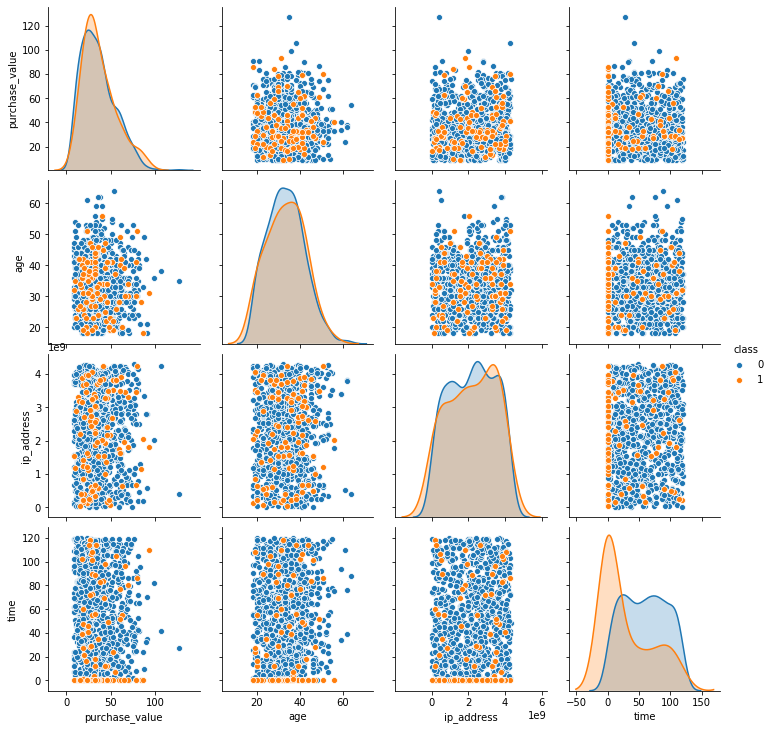

In [12]:
dataset_sample = data2.sample(1000) 
sns.pairplot(dataset_sample, hue = 'class')

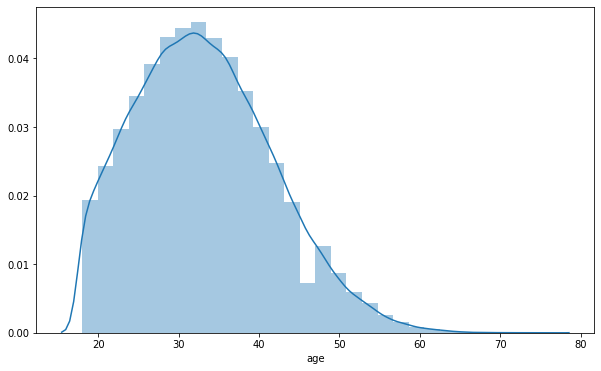

In [13]:
# Distribution de la variable Age

plt.figure(figsize=(10,6))
sns.distplot(data2['age'], kde=True, bins = 30)

plt.show()

0    136961
1     14151
Name: class, dtype: int64



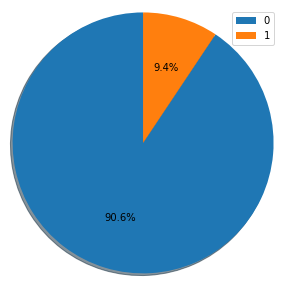

In [14]:
# Comptons les cas de fraude et d'absence de fraude et imprimons-les

occ_fraud= data2['class'].value_counts()
print(occ_fraud)
print()

plt.figure(figsize = (6, 5))
plt.pie(occ_fraud, autopct='%1.1f%%', shadow=True, startangle=90, radius=1.2)
plt.legend(occ_fraud.index)

plt.show()

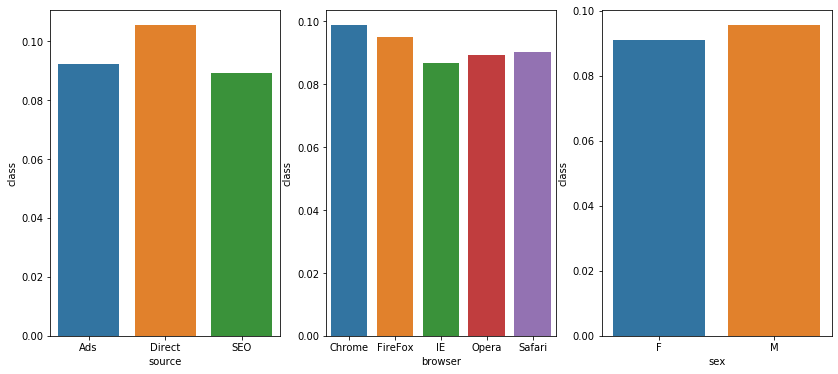

In [15]:
# Nous examinons la probabilité de fraude par catégorie

f, ax = plt.subplots(1,3, figsize =(14,6))
sns.barplot(dataset.groupby(by = "source").mean()["class"].index, dataset.groupby(by = "source").mean()["class"], ax=ax[0])
sns.barplot(dataset.groupby(by = "browser").mean()["class"].index, dataset.groupby(by = "browser").mean()["class"], ax =ax[1])
sns.barplot(dataset.groupby(by = "sex").mean()["class"].index, dataset.groupby(by = "sex").mean()["class"], ax = ax[2])

plt.show()

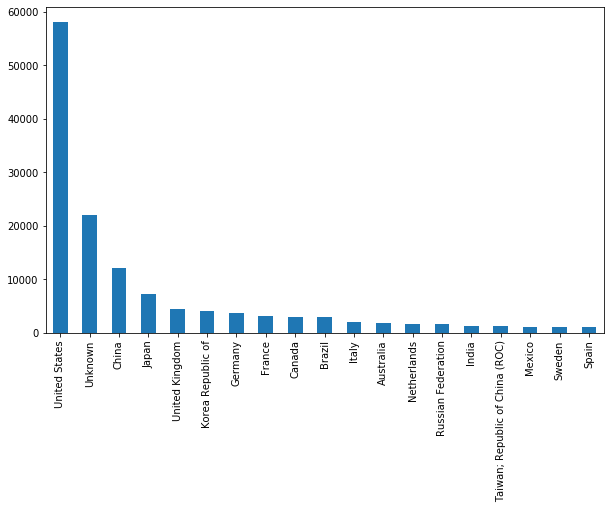

In [16]:
# Aperçu de la répartition par pays d'origine

plt.figure(figsize=(10,6))
dataset.IP_country.value_counts()[dataset.IP_country.value_counts() >1000].plot(kind="bar")

plt.show()

- Nous constatons que nous avons une quantité non négligeable d'inconnus. Nous conservons cette information car une adresse IP qui ne peut être retracé dans un pays peut être un indice d'une activité frauduleuse ..

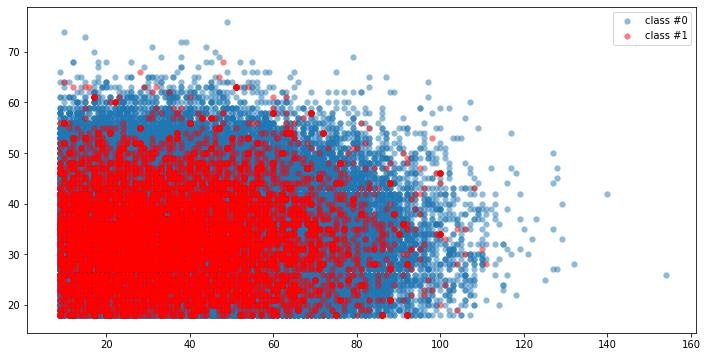

In [17]:
features_list = ['purchase_value', 'source', 'sex', 'age', 'ip_address']

X = data2.loc[:,features_list]
Y = data2.loc[:,'class']


def prep_data(data2: pd.DataFrame) -> (np.ndarray, np.ndarray):
   
    X = data2.loc[:, features_list].values
    Y = data2.loc[:,'class']
    return X, Y

# Définissons une fonction pour créer un diagramme de dispersion de nos données et étiquettes

def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[Y == 0, 0], X[Y == 0, 3], label="class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[Y == 1, 0], X[Y == 1, 3], label="class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

# Créer X et Y à partir de la fonction prep_data 

X, Y = prep_data(data2)

# Tracer nos données en exécutant notre fonction de données de tracé sur X et y

plt.figure(figsize = (12, 6))
plot_data(X, Y)

# IV. Matrice de corrélation

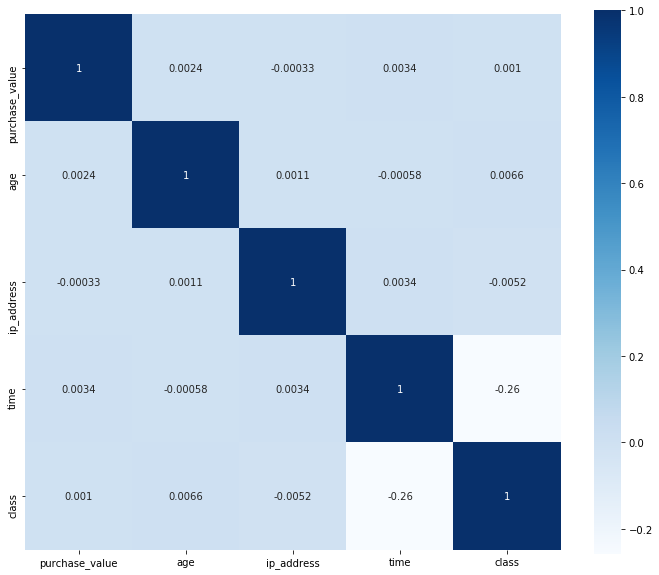

In [18]:
colormap = plt.cm.Blues
plt.figure(figsize=(12,10))
corr = data2[data2.columns].corr()
sns.heatmap(corr,square=True, cmap=colormap, linecolor='white',annot=True)

plt.show()

La matrice de corrélation montre que les variables explicatives sont faiblement corrélées. Neanmoins, on constate une corrélation assez importante entre la variable-cible **class** et la variable **time** qui representre la differnce entre le **signup_time** et **purchase_time**.

# V. Machine Learning

### Preprocessing

In [19]:
#sexe

data2['sex']=data2['sex'].map({'F':0,'M':1}).astype(int)

In [20]:
data2.source.unique()

array(['SEO', 'Ads', 'Direct'], dtype=object)

In [21]:
# Separate target variable Y from features X

print("Separating labels from features...")
features_list = ['purchase_value', 'source', 'sex', 'age', 'ip_address']

X = data2.loc[:,features_list]
Y = data2.loc[:,'class']

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

X :
   purchase_value source  sex  age    ip_address
0              34    SEO    1   39  7.327584e+08
1              16    Ads    0   53  3.503114e+08
2              15    SEO    1   53  2.621474e+09
3              44    SEO    1   41  3.840542e+09
4              39    Ads    1   45  4.155831e+08


In [22]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['purchase_value', 'sex', 'age', 'ip_address']  at positions  [0, 2, 3, 4]
Found categorical features  ['source']  at positions  [1]


In [23]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [24]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[21 'Direct' 0 39 1574176859.4623802]
 [20 'SEO' 1 25 1910384659.20348]
 [34 'Ads' 1 26 3157060061.69313]
 [61 'SEO' 1 29 2911793351.72256]
 [57 'Ads' 0 24 1564349716.54674]]
[[69 'Ads' 1 32 2788768186.96945]
 [35 'SEO' 1 31 1782347076.27697]]

[0 0 0 0 0]
[0 0]


In [25]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...

[[21 'Direct' 0 39 1574176859.4623802]
 [20 'SEO' 1 25 1910384659.20348]
 [34 'Ads' 1 26 3157060061.69313]
 [61 'SEO' 1 29 2911793351.72256]
 [57 'Ads' 0 24 1564349716.54674]]
...Done
[[ 1.          0.         -0.86792715 -1.18542175  0.67834581 -0.46230212]
 [ 0.          1.         -0.9224847   0.84358162 -0.94523103 -0.19334637]
 [ 0.          0.         -0.15867899  0.84358162 -0.82926125  0.80395504]
 [ 0.          1.          1.31437489  0.84358162 -0.48135193  0.60774933]
 [ 0.          0.          1.09614469 -1.18542175 -1.0612008  -0.47016353]]


In [26]:
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_test[0:5,:])

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...

[[69 'Ads' 1 32 2788768186.96945]
 [35 'SEO' 1 31 1782347076.27697]
 [16 'Ads' 1 35 301084738.561764]
 [42 'Ads' 1 29 3586026043.8896203]
 [30 'SEO' 0 35 3681708785.7506213]]
...Done
[[ 0.          0.          1.7508353   0.84358162 -0.13344261  0.50933304]
 [ 0.          1.         -0.10412144  0.84358162 -0.24941238 -0.29577244]
 [ 0.          0.         -1.14071491  0.84358162  0.21446671 -1.48073608]
 [ 0.          0.          0.27778142  0.84358162 -0.48135193  1.14711444]
 [ 0.          1.         -0.37690919 -1.18542175  0.21446671  1.22365765]]


### 1. Regression Logistique

In [27]:
# Train model
print("Train model...")
classifier = LogisticRegression() # regularized logit with regularization strength chosen by cross-val
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [28]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [29]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [30]:
print("Accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

Accuracy on train set :  0.9063521081322535
Accuracy on test set :  0.9063627039010026


In [31]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

f1-score on train set :  0.0
f1-score on test set :  0.0



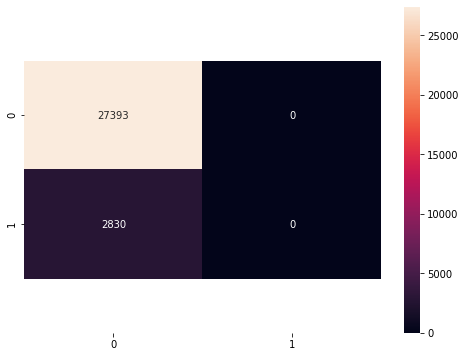

In [32]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(Y_test, Y_test_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

En utlisant le modèle de regression logistique, les resultats de prediction montrent qu'il y a pas eu de cas de fraude. Ce qui semble peu probable. Donc nous allons essayer d'améliorer notre prédiction en utlisant d'autres modèles.

### 2. Decision Tree

In [33]:
# Train model
print("Train model...")

classifier = DecisionTreeClassifier()

params = {
    'max_depth' : [4,6,8,10],
    'max_features':[2,3,4]
}

best_classifier = GridSearchCV(classifier, params)
best_classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [34]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [35]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [36]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()
print("Accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

f1-score on train set :  0.0943317472243092
f1-score on test set :  0.07970773829292595

Accuracy on train set :  0.910256516308349
Accuracy on test set :  0.9083148595440559


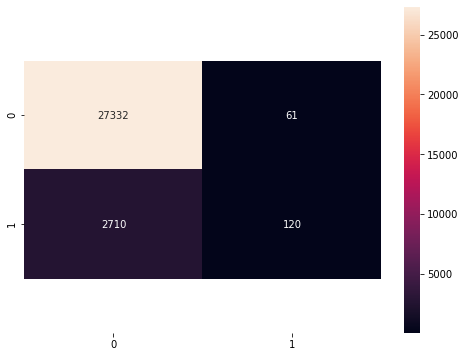

In [37]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(Y_test, Y_test_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Le modèle de l'arbre de decision amilore nos resultats, donc il semble être meilleur que les regressions logistiques dans ce cas de figure.

### 3. Random Forest

In [38]:
rf_classifier = RandomForestClassifier(n_estimators=20)
rf_classifier.fit(X_train, Y_train)
Y_train_pred = rf_classifier.predict(X_train)
Y_test_pred = rf_classifier.predict(X_test)

In [39]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()
print("Accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

f1-score on train set :  0.9459650987687129
f1-score on test set :  0.6673792218896965

Accuracy on train set :  0.9899080975109398
Accuracy on test set :  0.9485160308374417


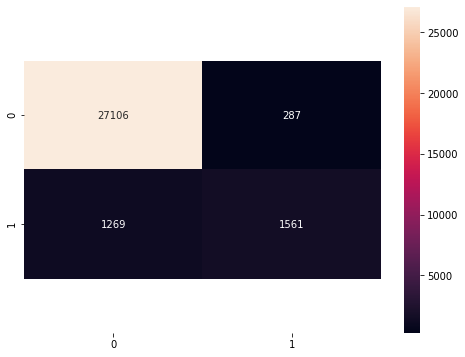

In [40]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(Y_test, Y_test_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Le modèle random Forest predit plus de cas de fraude par rapport aux modèles précedents.

### 4. Voting

In [41]:
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models = [SVC(), LogisticRegression(), DecisionTreeClassifier()]

In [42]:
for model in models:
    model.fit(X_train, Y_train)

In [43]:
for model in models:
    print(model.score(X_test, Y_test))

0.9063627039010026
0.9063627039010026
0.8970982364424445


In [44]:
preds = np.zeros(len(Y_test))
for model in models:
  preds+=model.predict(X_test) / len(models)

In [45]:
preds = preds > 0.5
preds = [1 if pred else 0 for pred in preds]
from sklearn.metrics import accuracy_score
accuracy_score(preds, Y_test)

0.9063627039010026

In [46]:
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(
    estimators = [
                  ("svc", SVC()), 
                  ("logreg", LogisticRegression()), 
                  ("tree", DecisionTreeClassifier())
                  ]
)

In [47]:
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9063627039010026

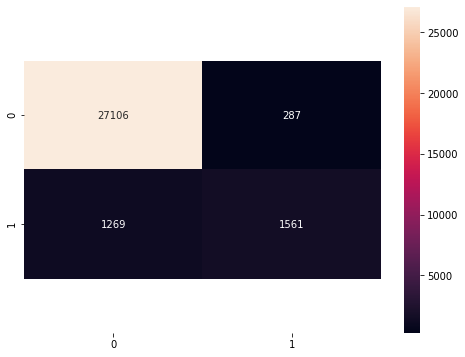

In [48]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(Y_test, Y_test_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Dans le but d'amèloirer les resultats, nous avons utilisé d'autres modèles, à savoir le **Voting**, qui utilise plusieurs modèles en même temps. Ce dernier ameliore les predictions (score).

### 5. Stacking

In [49]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(
    estimators = [
                  ("svc", SVC()), 
                  ("logreg", LogisticRegression()), 
                  ("tree", DecisionTreeClassifier())
                  ],
    final_estimator=LogisticRegression()
)

In [50]:
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9063627039010026

# Conclusion

L'analyse des données a montré que les fraudes ne representent que 9.4% de l'échantillon, indiquant un fort deséqilibre des classes. Concerant les modèles de machine de learning, les analyses montrent que les modèles de Random Forest et de Voting apportent plus de precision dans la prediction des fraudes dans les E-commerces.